# Error along the ellipse



In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table

import sys
sys.path.append('/Users/james/Dropbox/python/cubehelix/')
import cubehelix

In [18]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [19]:
CMAP1 = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)
CMAP2 = cubehelix.cmap(start=1.5, rot=-0.6, sat=1.8, reverse=True)

In [20]:
# SN 1987A Properties
t0 = Time({'year': 1987, 'month': 2, 'day': 23}, format='ymdhms')

c0_radec = SkyCoord.from_name('SN 1987A')

# Panagia (1999) https://ui.adsabs.harvard.edu/abs/1999IAUS..190..549P/abstract
d0 = 51.4 * u.kpc
d0_err= 1.2 * u.kpc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

In [21]:
print(c0_radec)
print(d0.to('pc'))

<SkyCoord (ICRS): (ra, dec) in deg
    (83.86675, -69.26974167)>
51400.0 pc


In [22]:
# https://arxiv.org/abs/2012.02061
GCNS_file = '../../lonely_stars/GCNS_cat.fits'
GCNS = Table.read(GCNS_file, format='fits')

# past me already did this, yay! 
# https://github.com/jradavenport/lonely_stars/blob/main/GCNS_KDTree.ipynb
c1 = SkyCoord(ra = GCNS['RA'] * u.degree,
              dec = GCNS['DEC'] * u.degree,
              distance= GCNS['DIST_50'] * u.kpc,
              frame='icrs')

len(GCNS)
# xyz = c1.transform_to(coord.Galactocentric)

331312

In [23]:
t1 = Time.now()
# t1 = Time({'year': 2088, 'month': 2, 'day': 23}, format='ymdhms')
dt = t1-t0

# dt.sec
# dt.jd
dt.to('year')

<Quantity 34.77928125 yr>

In [28]:
c = d0.to('lyr') / 2 # dist to foci from ellipse center
a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # the semi-major axis of ellipse
print(a-c)

d1 = (GCNS['DIST_50'] * u.kpc) # dist to GCNS stars

# OMG, astropy does the 3D distance computation between coordinates!
# need to work out how to propogate errors here, but it's pretty rad...
d2 = c1.separation_3d(c0) # dist from GCNS to SN 1987A

17.389640626250184 lyr


In [110]:
Alpha = c1.separation(c0).to('rad')

Z = np.sqrt( (c)**2 + d1.to('lyr')**2 - (2 * c * d1.to('lyr') * np.cos(Alpha.to('rad').value)) ) # law of cosines

Theta = np.arcsin(np.sin(Alpha.to('rad').value) * d1.to('lyr') / Z) # law of sines

e = c/a
b = np.sqrt(a**2 - c**2)
Phi = np.arctan(b/(a * e * np.sin(Theta)))

Gaia_Err = ((GCNS['DIST_84'] - GCNS['DIST_50']) + (GCNS['DIST_50'] - GCNS['DIST_16']))/2 * u.kpc
SCATTER = (Gaia_Err * np.sin(Phi)).to('lyr')
SCATTER

<Quantity [ 0.5618179 ,  2.16773364,  0.33386026, ...,  0.21165892,
           20.00010885,  8.68883029] lyr>

## NEED TO DO:
This *looks* right... 
- Alpha is between 0 and 180deg (angular dist from every star to SN1987A)
- Theta is small b/c the ellipse is VERY ellongated, and all stars are very nearby us (so isolated to the extreme right side of the ellipse)
    - should make a figure of entire dataset to scale, color by theta..
- Phi is directly correlated with Theta, and is 90 (up/down) at theta=0 (behind us)

I need to make some tests or illustrations that show that the Phi that I'm computing is right. Maybe do for 1000 steps around the ellipse in theta? Or better yet, 1000 steps in Alpha... i did that in another notebook I think.

Text(0, 0.5, '$\\Theta$')

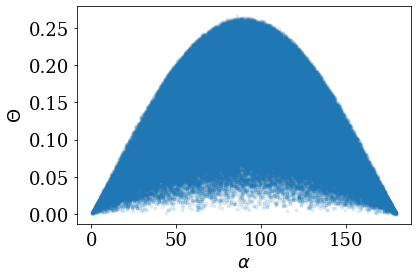

In [109]:
plt.figure()
plt.scatter(Alpha.to('deg').value[10000:],Theta.to('deg').value[10000:], marker='.',alpha=0.1)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\Theta$')
# Alpha.value

Text(0.5, 0, '$\\Theta$')

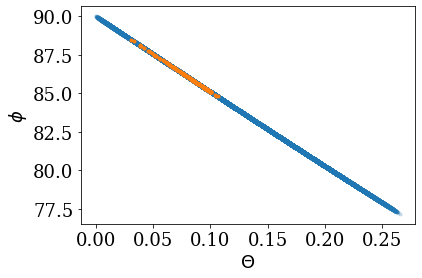

In [119]:
plt.figure()
plt.scatter(Theta.to('deg').value[10000:], Phi.to('deg').value[10000:],marker='.',alpha=0.1)
plt.scatter(Theta.to('deg')[OYES], Phi.to('deg').value[OYES],marker='.')
plt.ylabel(r'$\phi$')
plt.xlabel(r'$\Theta$')
# Alpha.value

Text(0.5, 0, '$\\alpha$')

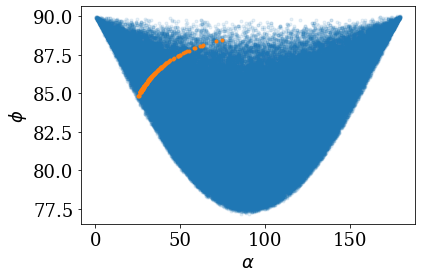

In [120]:
plt.figure()
plt.scatter(Alpha.to('deg').value[10000:], Phi.to('deg').value[10000:],marker='.',alpha=0.1)
plt.scatter(Alpha.to('deg')[OYES], Phi.to('deg').value[OYES],marker='.')
plt.ylabel(r'$\phi$')
plt.xlabel(r'$\alpha$')
# Alpha.value

In [9]:
# A few things to compute for each GCNS object:

# 1. has it seen SN 1987A yet?
SNYES = d2.to('lyr').value <= (d0.to('lyr') + (dt.to('s') * const.c)).to('lyr').value
SNNO = ~SNYES

# 2. is it within the "SETI ellipse"?
EYES = (d1.to('lyr').value + d2.to('lyr').value) <= (2 * a.to('lyr').value)
ENO = ~EYES

# 3. is it within some tolerance of being ON the ellipse?
#    this could be within some range in distance or in time, thanks to speed of light...
tol = 0.1 # in lyr
OYES = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a.to('lyr').value)) <= tol

In [10]:
print(len(d1))
print(sum(SNYES), sum(SNNO), sum(EYES), sum(OYES))
print(sum(SNYES) / (sum(SNYES) + sum(SNNO)))
print(sum(SNNO) / (sum(SNYES) + sum(SNNO)))
print(sum(EYES) / (sum(SNYES) + sum(SNNO)))

331312
192135 139177 25484 134
0.579921644854397
0.42007835514560293
0.07691843338001642


In [11]:
# functions for drawing ellipses and circles to scale, BUT NOT ROTATED
# b/c I'm lazy...
def echoxy0(t, c, Ntheta=1000, foci=False):
    '''
    t: time since SNe in years
    c: half the dist to the SNe in lightyears
    '''

    a = 0.5 * (t + np.sqrt(t**2 + 4 * (c**2)))
    b = np.sqrt(0.5 * (t**2 + np.sqrt(t**4 + 4 * t**2 * c**2)))
    
    if foci:
#         foci_length = np.sqrt(np.abs(a**2 - b**2))
        fx = np.array([-c, c]) - c
        fy = np.array([0.,0.])
        return fx* u.lyr, fy* u.lyr

    else:
        theta = np.linspace(0, 2*np.pi, Ntheta) # the angle about the origin

        x = a * np.cos(theta) - c
        y = b * np.sin(theta)
        return x * u.lyr, y * u.lyr
    
    
def circxy0(t, c, x0=None,y0=None, Ntheta=1000):
    '''
    t: time since SNe in years
    c: half the dist to the SNe in lightyears
    '''
    a = 0.5 * (t + np.sqrt(t**2 + 4 * (c**2)))
    da = np.abs(a - c)
    acirc = a + da + c

    theta = np.linspace(0, 2*np.pi, Ntheta) # the angle about the origin
    
    x = acirc * np.cos(theta) - 2*c 
    y = acirc * np.sin(theta)        

    return x * u.lyr, y * u.lyr

def circxy(t, c, x0, y0, Ntheta=1000):
    r = 2*c + t
    theta = np.linspace(0, 2*np.pi, Ntheta) # the angle about the origin
    x = r * np.cos(theta) + x0
    y = r * np.sin(theta) + y0
    return x * u.lyr, y * u.lyr




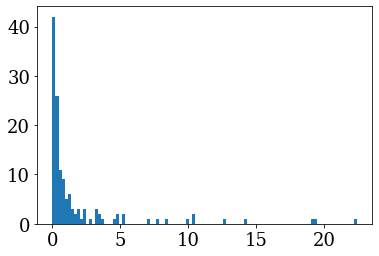

In [117]:
_ = plt.hist(SCATTER.value[OYES],bins=100)

In [13]:
t=dt.to('year').value

xyz87 = c0.transform_to(coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8*u.kpc))
c1987_yz = np.sqrt(xyz87.y.to('lyr').value**2 + xyz87.z.to('lyr').value**2)
ang1987_yz = np.arcsin(xyz87.z.to('lyr').value/c1987_yz)
# print(ang1987_yz)

fx0,fy0 = echoxy0(t, c1987_yz/2, foci=True)
fx,fy = echoxy0(t, c1987_yz/2 , Ntheta=10000)

xpos = (fx - fx0[1]).to('pc')
ypos = fy.to('pc')

new_xpos = xpos * np.cos(ang1987_yz) + ypos*np.sin(ang1987_yz)  # Y
new_ypos = -xpos * np.sin(ang1987_yz) + ypos*np.cos(ang1987_yz) # Z


xpos0, ypos0 = xpos, ypos
new_xpos0, new_ypos0 = new_xpos, new_ypos

(-55.0, 15.0)

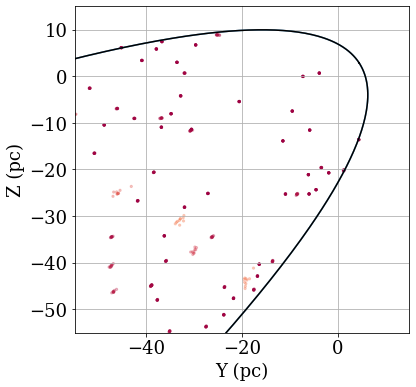

In [114]:
# lets inject some errors into the ellipse...
plt.figure(figsize=(6,6))
t=dt.to('year').value

xyz87 = c0.transform_to(coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8*u.kpc))
plt.scatter(xyz87.y.to('pc').value, xyz87.z.to('pc').value, c='C2', marker='*', s=100)

Nsim=10
for k in range(Nsim):
    dc = 1.2/2*np.random.normal(size=1) * u.kpc
    
    fx0,fy0 = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, foci=True)
    fx,fy = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, Ntheta=10000)
#     cx,cy = circxy0(t, c.value + dc.to('lyr').value, Ntheta=10000)

    xpos = (fx - fx0[1]).to('pc')
    ypos = fy.to('pc')

    new_xpos = xpos * np.cos(ang1987_yz) + ypos*np.sin(ang1987_yz)  # Y
    new_ypos = -xpos * np.sin(ang1987_yz) + ypos*np.cos(ang1987_yz) # Z

    plt.plot(new_xpos, new_ypos, alpha=0.1, c='C0')

    ddist = np.abs((GCNS['DIST_16'] - GCNS['DIST_84'])/2) * np.random.normal(size=len(GCNS['DIST_50']))
    c1 = SkyCoord(ra = (GCNS['RA']) * u.degree,
              dec = (GCNS['DEC']) * u.degree,
              frame='icrs')
    # directional offset drops distance... so i dont add it until next
    c2 = c1.directional_offset_by(np.random.uniform(high=360,size=len(GCNS['RA']))*u.deg, 
                                  np.sqrt(GCNS['RA_ERROR']**2 + GCNS['DEC_ERROR']**2)*u.deg)
    c3 = SkyCoord(ra=c2.ra, dec=c2.dec,
                  distance= (GCNS['DIST_50'] + ddist) * u.kpc,
                  frame='icrs')
    xyz = c3.transform_to(coord.Galactocentric(z_sun=0, galcen_distance=8*u.kpc))
#     plt.scatter(xyz.y.to('pc').value[OYES], xyz.z.to('pc').value[OYES], 
#                 s=20, alpha=0.3, c='r', marker='.')
    plt.scatter(xyz.y.to('pc').value[OYES], xyz.z.to('pc').value[OYES], 
                s=20, alpha=0.3, c=SCATTER.value[OYES], marker='.', cmap=plt.cm.Spectral)


plt.plot(new_xpos0, new_ypos0, c='k')
plt.grid(True)
plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')

plt.xlim(-55,15) # center near us
plt.ylim(-55,15)
# plt.savefig('dist_err1.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')


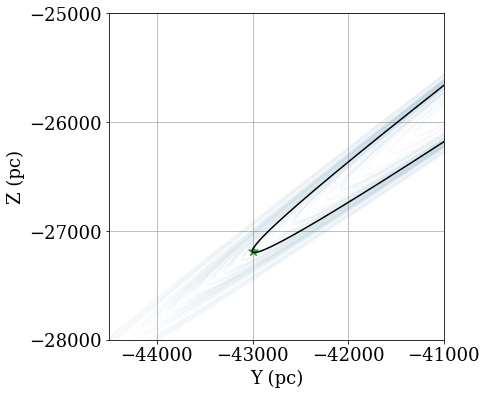

In [15]:
# lets inject some errors into the ellipse...
plt.figure(figsize=(6,6))
plt.scatter(xyz87.y.to('pc').value, xyz87.z.to('pc').value, c='C2', marker='*', s=100)

Nsim=100
for k in range(Nsim):
    dc = 1.2/2*np.random.normal(size=1) * u.kpc
    
    fx0,fy0 = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, foci=True)
    fx,fy = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, Ntheta=10000)
#     cx,cy = circxy0(t, c.value + dc.to('lyr').value, Ntheta=10000)

    xpos = (fx - fx0[1]).to('pc')
    ypos = fy.to('pc')

    new_xpos = xpos * np.cos(ang1987_yz) + ypos*np.sin(ang1987_yz)  # Y
    new_ypos = -xpos * np.sin(ang1987_yz) + ypos*np.cos(ang1987_yz) # Z

    plt.plot(new_xpos, new_ypos, alpha=0.02, c='C0')
    
plt.plot(new_xpos0, new_ypos0, c='k')
plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')

plt.xlim(-44500,-41500) # center near LMC
plt.ylim(-28000,-25000)
plt.xticks([-44000, -43000,-42000, -41000])
plt.yticks([-28000,-27000,-26000,-25000])
plt.grid(True)

# plt.savefig('dist_err2.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')
